In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import matplotlib.pyplot as plt 
import matplotlib
plt.rcParams.update(tex_fonts)


matplotlib.rc('lines', linewidth=2, markersize=3)

def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 500.02908
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
import pandas as pd
from matplotlib.gridspec import GridSpec

In [118]:
#### WESTERN EUROPE ####

df_list = []
df = pd.read_csv('FAO DATA - Western Europe/FAOSTAT_data_en_11-23-2023_TOTAL_PRODUCTIONcsv.csv')
df_list.append(df)
df = pd.read_csv('FAO DATA - Western Europe/FAOSTAT_data_en_11-23-2023_CROPLAND_AREAcsv.csv')
df_list.append(df)
df = pd.read_csv('FAO DATA - Western Europe/FAOSTAT_data_en_YIELD.csv')
df_list.append(df)
df = pd.read_csv('FAO DATA - Western Europe/FAOSTAT_data_en_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('FAO DATA - Western Europe/FAOSTAT_data_en_11-23-2023_PESTICIDES.csv')
df_list.append(df)
df_Price = pd.read_csv('Our World in Data/Real commodity prices, 1850-2015.csv')
condition = (df_Price.loc[0,:] == 'Wheat') 
condition[0] = True
df_cut = df_Price.loc[1:,condition]
df_cut = df_cut.rename(columns={"Unnamed: 0": "Year", "Unnamed: 12": "Value"})
df_cut = df_cut.astype('float')
df_list.append(df_cut[df_cut['Year'] >= 1961])

#### FRANCE ####

# df_list = []
# df = pd.read_csv('FAO DATA - France/FAOSTAT_data_TOTAL_PRODUCTION.csv')
# df_list.append(df)
# df = pd.read_csv('FAO DATA - France/FAOSTAT_data_AREA.csv')
# df_list.append(df)
# df = pd.read_csv('FAO DATA - France/FAOSTAT_data_YIELD.csv')
# df_list.append(df)
# df = pd.read_csv('FAO DATA - France/FAOSTAT_data_FERTILIZER.csv')
# df_list.append(df)
# df = pd.read_csv('FAO DATA - France/FAOSTAT_data_PESTICIDE.csv')
# df_list.append(df)

C:\Users\fortu\AppData\Local\Temp\ipykernel_11308\843785899.py:147: RuntimeWarning: invalid value encountered in divide
  return (self.land_type == 'C') * (self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, 0)) / self.productivity


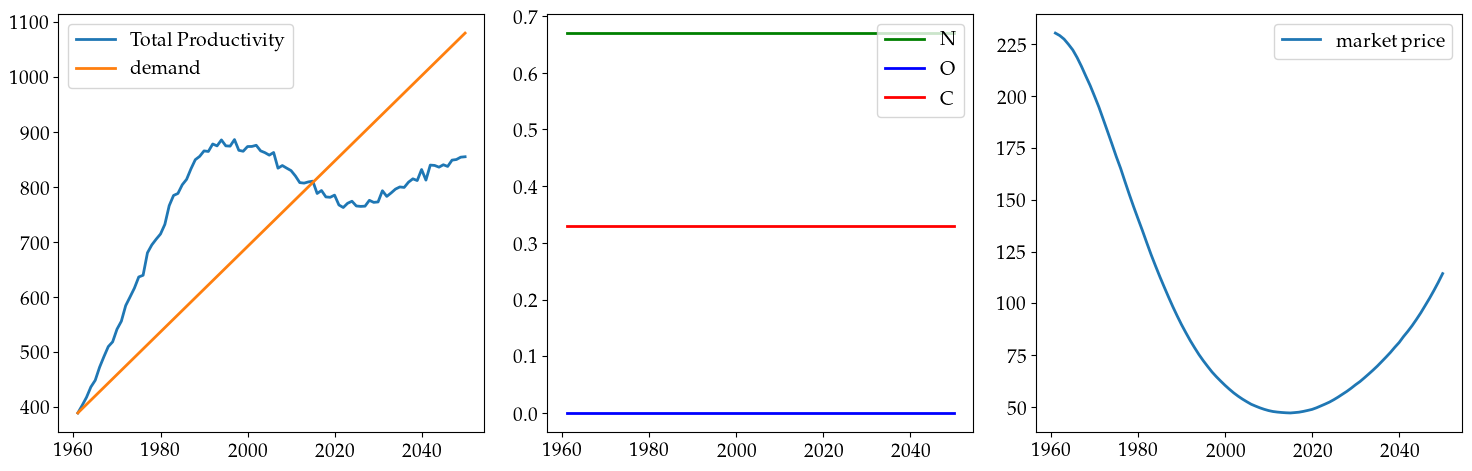

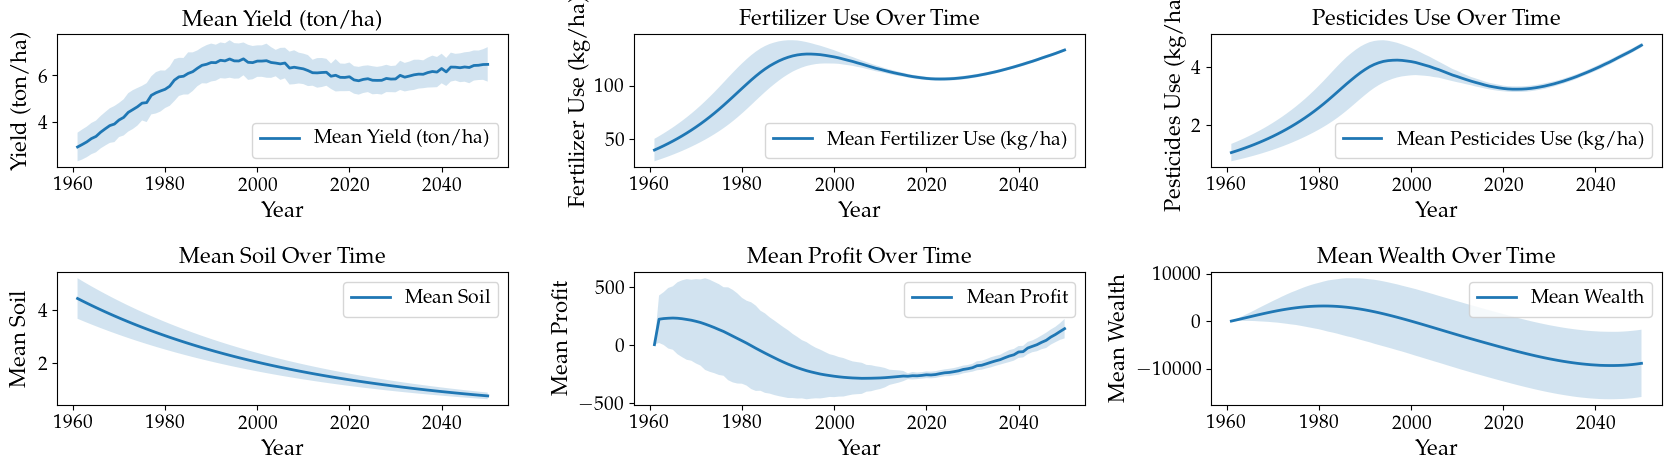

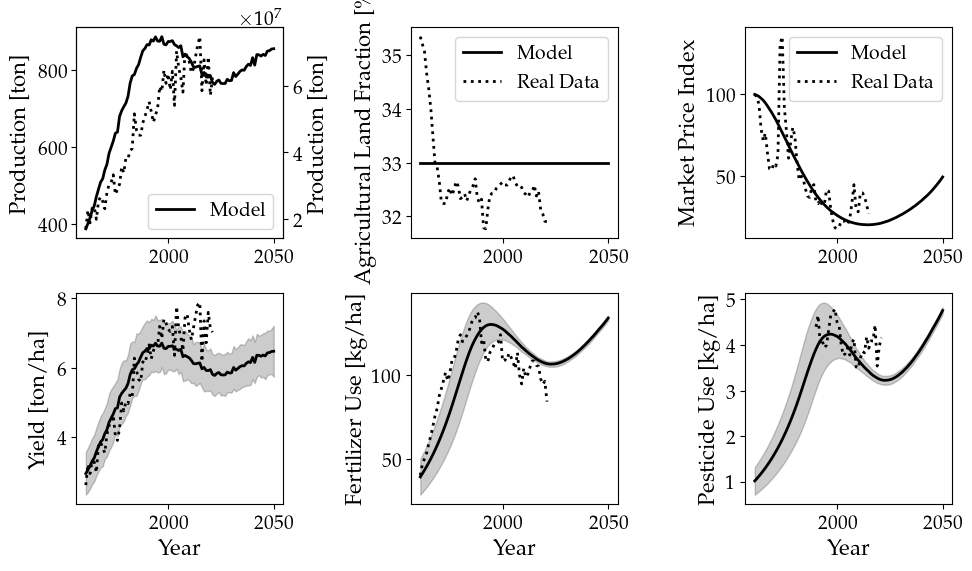

In [290]:
np.random.seed(42)

class Landscape:
    def __init__(self, size, frac_conventional, frac_organic, frac_natural, mean_initial_fertilizer = 40, std_initial_fertilizer = 10, mean_initial_pesticides = 3, std_initial_pesticides = 0.5, \
                    mean_soil_health_agri = 1, std_soil_health_agri = 0,\
                        y_max = 8, Nutrient_uptake_efficiency = 1, Nutrient_release_SOM = 30, N_req = 70, \
                            Maximum_Pest_impact = 0.2, biodiversity_vs_pesticides_protection = 0.3, Pesticides_required = 5, \
                                SOM_rate_conventional = -.02, SOM_rate_organic = 0.025, SOM_rate_natural = 0.05, biodiversity_organic = 0.05, \
                                    Fertilizer_price = 1, Pesticide_price = 30, fixed_cost_conventional = 500, Fertilizer_choice_profit_impact = 0.2, Fertilizer_choice_other_farmer = 0.1, threshold_base = 0.1, \
                                        subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 0
                                                ):
            
        self.size = size

        # Environmental variables
        self.y_max = y_max # Maximum Yield [ton/ha]
        self.Nutrient_uptake_efficiency = Nutrient_uptake_efficiency # Nutrient uptake efficiency 
        self.Nutrient_release_SOM = Nutrient_release_SOM # Nutrient release from SOM decomposition [Kg/ha]
        self.N_req = N_req # Nutrient requirement for growth [ton/ha]
        self.Maximum_Pest_impact = Maximum_Pest_impact # Maximum pest impact 
        self.biodiversity_vs_pesticides_protection = biodiversity_vs_pesticides_protection # Protection potential of biodiversity vs pesticides
        self.Pesticides_required = Pesticides_required # Required Pesticides [kg]
        self.SOM_rate_conventional = SOM_rate_conventional # SOM decomposition rate under conventional farming
        self.SOM_rate_organic = SOM_rate_organic # SOM regeneration rate under organic farming
        self.SOM_rate_natural = SOM_rate_natural # SOM regeneration rate under natural 
        self.biodiversity_organic = biodiversity_organic # Biodiversity contribution from organic

        # Economic variables
        self.Fertilizer_price = Fertilizer_price # Cost per kilogram of fertilizer
        self.Pesticide_price = Pesticide_price # Cost per kilogram of pesticide
        self.fixed_cost_conventional = fixed_cost_conventional # Fixed cost for conventional production
        self.Fertilizer_choice_profit_impact = Fertilizer_choice_profit_impact
        self.Fertilizer_choice_other_farmer = Fertilizer_choice_other_farmer
        self.threshold_base = threshold_base # Production switch threshold 

        # Policy variables
        self.subsidy_strength_production = subsidy_strength_production
        self.subsidy_strength_organic = subsidy_strength_organic
        self.policy_strength_natural = policy_strength_natural


        # Initialize matrices
        if frac_conventional + frac_natural + frac_organic != 1:
            raise AttributeError("Input the right amount of initial fractions")
        
        self.initialize_land_types(frac_conventional, frac_organic, frac_natural)
        self.soil_health, self.biodiversity = self.initialize_soil_health_and_biodiversity(mean_soil_health_agri, std_soil_health_agri)

        # Calculate initial productivity
        self.pesticides = (self.land_type == 'C') * np.clip(np.random.normal(mean_initial_pesticides, std_initial_pesticides, (size, size)), 0, np.inf)
        self.fertilizer = (self.land_type == 'C') * np.clip(np.random.normal(mean_initial_fertilizer, std_initial_fertilizer, (size, size)), 0, np.inf)
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)
        self.initial_productivity = np.sum(self.productivity)
        self.market_demand = self.initial_productivity
        self.prices = (self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, np.nan)) / self.productivity
        self.market_price = 1.5 * (mean_initial_fertilizer * self.Fertilizer_price + mean_initial_pesticides * self.Pesticide_price + self.fixed_cost_conventional)/np.mean(self.productivity[self.land_type != 'N']) 
        self.profits = np.zeros((self.size, self.size)) 
        self.wealth = np.zeros((self.size, self.size)) + self.profits

        # Initialize data for plotting
        self.data = {'total_productivity': [], 'demand': [], 'O': [], 'C': [], 'N':[], 'market_price': [], 'total_economic_value': [], 'land_type_changes': [], \
                     'mean_Y': [], 'std_Y': [], 'mean_F':[], 'std_F':[], 'mean_P': [], 'std_P':[], 'mean_Soil':[], 'std_Soil':[], 'mean_Profit':[], 'std_Profit':[], \
                         'mean_Price':[], 'std_Price':[], 'mean_wealth':[], 'std_wealth':[] }

    def initialize_land_types(self, frac_conventional, frac_organic, frac_natural):
        total_cells = self.size * self.size
        num_conventional = int(total_cells * frac_conventional)
        num_organic = int(total_cells * frac_organic)
        num_natural = total_cells - num_conventional - num_organic

        land_types_flat = (['C'] * num_conventional +
                           ['O'] * num_organic +
                           ['N'] * num_natural)

        np.random.shuffle(land_types_flat)
        self.land_type = np.array(land_types_flat).reshape((self.size, self.size))

    def initialize_soil_health_and_biodiversity(self, mean, std):
        soil_health = np.zeros((self.size, self.size))
        soil_health[self.land_type != 'N'] = np.random.normal(mean, std, (self.size, self.size))[self.land_type != 'N']
        soil_health[self.land_type == 'N'] = 1
        soil_health = np.clip(soil_health, 0, 1)
        
        biodiversity = np.zeros((self.size, self.size))
        biodiversity[self.land_type == 'N'] = 1

        return soil_health, biodiversity
    
    def update_soil_health(self, omega = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.soil_health, kernel, mode='wrap')

        delta_h = np.where(self.land_type == 'O', self.SOM_rate_organic, self.SOM_rate_conventional)
        delta_h[self.land_type == 'N'] = self.SOM_rate_natural
        self.soil_health += (delta_h + omega * avg_neighbors) * self.soil_health
        self.land_type[self.soil_health < 0] = 'N'
        self.wealth[self.soil_health < 0] = 0
        self.soil_health = np.clip(self.soil_health, 0, 1)

    def update_biodiversity(self, omega = 0.):

        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]]) / 8.0
        avg_neighbors = convolve(self.biodiversity, kernel, mode='wrap')
        delta_b = np.where(self.land_type == 'O', 0.01, -0.05)
        delta_b[self.land_type == 'N'] = 0.05
        self.biodiversity += (delta_b + omega * avg_neighbors) * self.biodiversity
        self.biodiversity = np.clip(self.biodiversity, 0, 1)
    
    def productionfunction(self, fertilizer, pesticide):
        production =  self.y_max * (self.soil_health)**0.05 *  (1 - np.exp(-1/self.N_req * ( self.soil_health**self.Nutrient_uptake_efficiency * fertilizer + self.Nutrient_release_SOM * self.soil_health))) \
                        * (1 - self.Maximum_Pest_impact * np.exp( - self.biodiversity_vs_pesticides_protection * self.biodiversity - (1 - self.biodiversity_vs_pesticides_protection) * pesticide / self.Pesticides_required)) \
                            * (1 + np.random.normal(0, 0.1, (self.size, self.size)))\
                                * (self.land_type != "N")
        return production
    
    def planning_phase(self):
        expected_market_price = self.market_price
        
        Fertilizer_change = np.linspace(0.5,1.5,20)
        Pest_change = np.linspace(0.5,1.5,20)
        mesh = np.array(np.meshgrid(Fertilizer_change, Pest_change)).T.reshape(-1,2)


        F_try = self.fertilizer * mesh[:,0][:, np.newaxis, np.newaxis]
        P_try = self.pesticides * mesh[:,1][:, np.newaxis, np.newaxis]

        Profit_try = (expected_market_price + self.subsidy_strength_production) * self.productionfunction(F_try, P_try) - self.Fertilizer_price * F_try - self.Pesticide_price * P_try - self.fixed_cost_conventional
        # print(np.max(P_try, axis = 0) * (self.land_type != 'N'))
        F_opt = F_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        P_opt = P_try[np.argmax(Profit_try, axis=0), np.arange(F_try.shape[1])[:, np.newaxis], np.arange(F_try.shape[2])]
        # F_opt = self.soil_health**-self.Nutrient_uptake_efficiency * ( - self.N_req * np.log(self.N_req * self.Fertilizer_price / self.market_price / self.y_max) - self.Nutrient_release_SOM * self.soil_health )
        # kernel = np.array([[1, 1, 1],
        #                    [1, 0, 1],
        #                    [1, 1, 1]]) / 8.0
        # avg_fertilizer_neighbors = convolve(self.fertilizer * (self.land_type == 'C'), kernel, mode='wrap')

        fertilizer = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.fertilizer + self.Fertilizer_choice_profit_impact * F_opt + self.Fertilizer_choice_other_farmer * np.mean(self.fertilizer[self.land_type == 'C'])
        pesticide = (1 - self.Fertilizer_choice_profit_impact - self.Fertilizer_choice_other_farmer) * self.pesticides + self.Fertilizer_choice_profit_impact * P_opt + self.Fertilizer_choice_other_farmer * np.mean(self.pesticides[self.land_type == 'C'])
        
        return fertilizer * (self.land_type != 'N'), pesticide * (self.land_type != 'N')

    def computeprices(self):
        return (self.land_type == 'C') * (self.Fertilizer_price * self.fertilizer + self.Pesticide_price * self.pesticides + np.where(self.land_type == 'C', self.fixed_cost_conventional, 0)) / self.productivity

    def compute_sellingmatrix_price(self):
        # Flatten and sort the production values along with their indices
        flattened_productivity = self.productivity.ravel()
        sorted_indices = np.argsort(flattened_productivity)[::-1]
        sorted_productivity = flattened_productivity[sorted_indices]

        # Calculate sold fractions
        cumulative_production = np.cumsum(sorted_productivity)
        sold_fraction = np.zeros_like(sorted_productivity)

        # Find the index where demand is just met or exceeded
        meet_demand_index = np.argmax(cumulative_production >= self.market_demand)

        # If demand is less than or equal to total production
        if cumulative_production[meet_demand_index] >= self.market_demand:
            # Units fully sold
            sold_fraction[:meet_demand_index] = 1
            # The last unit might be partially sold
            if cumulative_production[meet_demand_index] > self.market_demand:
                sold_fraction[meet_demand_index] = (self.market_demand - cumulative_production[meet_demand_index - 1]) / sorted_productivity[meet_demand_index]
        else:
            # All units are sold
            sold_fraction[:] = 1

        # Calculate market price
        last_accepted_production = sorted_productivity[meet_demand_index]
        market_price = self.prices.ravel()[sorted_indices][meet_demand_index] / last_accepted_production 

        # Reconstruct the matrix with the sold fractions in their original positions
        reconstructed_matrix = np.zeros_like(sold_fraction)
        reconstructed_matrix[sorted_indices] = sold_fraction
        return reconstructed_matrix.reshape(self.productivity.shape), market_price
    
    def computeprofit(self):
        selling_matrix, p_M = self.compute_sellingmatrix_price()
        # selling_matrix = np.ones((self.size, self.size))
        self.market_price = self.market_price * (1 + 0.15 * (self.market_demand - np.sum(self.productivity[self.land_type == 'C'])) / np.sum(self.productivity[self.land_type == 'C']))    
        profit = (self.land_type != 'N') * (selling_matrix * self.productivity * (self.market_price + self.subsidy_strength_production) \
                                            - self.Fertilizer_price * self.fertilizer \
                                                - self.Pesticide_price * self.pesticides \
                                                    + np.where(self.land_type == 'O', self.subsidy_strength_organic, 0) \
                                                        - np.where(self.land_type == 'C', self.fixed_cost_conventional, 0))
        
        return profit
    
    def update_productivity_and_economic_value(self):
        self.fertilizer, self.pesticides = self.planning_phase()
        self.productivity = self.productionfunction(self.fertilizer, self.pesticides)        
        self.prices = self.computeprices()
        self.profits = self.computeprofit()
        self.wealth += self.profits
        bankrupt = self.wealth < -1
        # self.land_type[bankrupt] = 'N'
        # self.wealth[bankrupt] = 0

    def switch_farming_technique(self, gamma = 0.):
        kernel = np.array([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]])/8
        organic_neighbors = convolve(self.land_type == 'O', kernel, mode='wrap', output=float)
        conventional_neighbors = convolve(self.land_type == 'C', kernel, mode='wrap', output=float)
        
        threshold_to_organic = self.threshold_base * (1 + gamma * (conventional_neighbors-organic_neighbors)/(conventional_neighbors+organic_neighbors))
        threshold_to_conventional = self.threshold_base * (1 + gamma * (conventional_neighbors-organic_neighbors)/(conventional_neighbors+organic_neighbors))

        exp_profit_organic = self.expectedprofit(self.market_price, farming_type='O')
        exp_profit_conventional = self.expectedprofit(self.market_price, farming_type='C')
        
        switch_to_organic = (self.land_type == 'C') & ( (exp_profit_organic - exp_profit_conventional) / self.fixed_cost_conventional > threshold_to_organic)
        switch_to_conventional = (self.land_type == 'O') & ( (exp_profit_conventional - exp_profit_organic) / self.fixed_cost_conventional > threshold_to_conventional)

        self.land_type[switch_to_organic] = 'O'
        self.land_type[switch_to_conventional] = 'C'

    def introduce_new_farmers(self):
        
        if np.any(self.land_type == 'N'):
            if (self.market_demand - np.sum(self.productivity)) > self.policy_strength_natural:
                # Select candidates
                numbers_of_new_farmers = int(min(np.sum(self.land_type == 'N'), np.ceil((self.market_demand - np.sum(self.productivity)) / np.mean(self.productivity[self.productivity > 0]))))
                candidate_list = np.argwhere(self.land_type == 'N')
                biodiversity_candidates = self.biodiversity[self.land_type == 'N'].ravel()
                probability_list = (1.1 - biodiversity_candidates**self.policy_strength_natural) / np.sum(1.1 - biodiversity_candidates**self.policy_strength_natural)
                candidate_selected = np.random.choice(np.arange(candidate_list.shape[0]), size=numbers_of_new_farmers, p=probability_list, replace=False)
                candidate_matrix = np.full((self.size, self.size), False, dtype=bool)
                candidate_matrix[candidate_list[candidate_selected][:,0], candidate_list[candidate_selected][:,1]]=True
                
                self.land_type[candidate_matrix] = 'C'
                self.wealth[candidate_matrix] = self.fixed_cost_conventional

                # Choose organiv vs conventional
                # expected_profit_organic = self.expectedprofit(self.market_price, farming_type='O')
                # expected_profit_convetional = self.expectedprofit(self.market_price, farming_type='O')
                # prob_1 = (np.sum(self.land_type == 'O')  - np.sum(self.land_type == 'C')) / (np.sum(self.land_type == 'O') + np.sum(self.land_type == 'C'))
                # prob_2 = (expected_profit_organic - expected_profit_convetional)/(expected_profit_convetional + expected_profit_organic)
                # prob_organic = 0.5 + 0.5 * prob_1 * prob_2 
                # organic = np.random.rand(self.size, self.size) < np.array(prob_organic)

                # self.land_type[candidate_matrix * organic] = 'O'
                # self.land_type[candidate_matrix * (1 - organic)] = 'C'

    def update_demand(self):
        self.market_demand += 0.02 * self.initial_productivity 

    def simulate_year(self):
        self.aggregate_data()
        self.update_productivity_and_economic_value()
        self.update_soil_health()
        self.update_biodiversity()
        # self.switch_farming_technique()
        # self.introduce_new_farmers()
        self.update_demand()
        
    def aggregate_data(self):
        self.data['total_productivity'].append(np.sum(self.productivity))
        self.data['demand'].append(self.market_demand)
        self.data['market_price'].append(self.market_price)
        self.data['total_economic_value'].append(np.sum(self.wealth))
        self.data['N'].append(np.sum(self.land_type=='N') / self.size**2)
        self.data['O'].append(np.sum(self.land_type=='O') / self.size**2)
        self.data['C'].append(np.sum(self.land_type=='C') / self.size**2)
        self.data['mean_Y'].append(np.mean(self.productivity[self.land_type!='N']))
        self.data['std_Y'].append(np.std(self.productivity[self.land_type!='N']))
        self.data['mean_F'].append(np.mean(self.fertilizer[self.land_type !='N']))
        self.data['std_F'].append(np.std(self.fertilizer[self.land_type!='N']))
        self.data['mean_P'].append(np.mean(self.pesticides[self.land_type!='N']))
        self.data['std_P'].append(np.std(self.pesticides[self.land_type!='N']))
        self.data['mean_Soil'].append(np.mean(self.soil_health[self.land_type!='N']))
        self.data['std_Soil'].append(np.std(self.soil_health[self.land_type!='N']))
        self.data['mean_Profit'].append(np.mean(self.profits[self.land_type!='N']))
        self.data['std_Profit'].append(np.std(self.profits[self.land_type!='N']))
        self.data['mean_Price'].append(np.mean(self.prices[self.land_type!='N']))
        self.data['std_Price'].append(np.std(self.prices[self.land_type!='N']))
        self.data['mean_wealth'].append(np.mean(self.wealth[self.land_type!='N']))
        self.data['std_wealth'].append(np.std(self.wealth[self.land_type!='N']))       

        # Additional data aggregation can be added here

    def plot_aggregated_data(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        years = np.arange(1961, 1961 + len(landscape.data['mean_F']))

        ax = axes[0]
        ax.plot(years, self.data['total_productivity'], label='Total Productivity')
        ax.plot(years, self.data['demand'], label = 'demand')
        ax.legend()

        ax = axes[1]
        ax.plot(years, self.data['N'], label='N', color='g')
        ax.plot(years, self.data['O'], label='O', color='b')
        ax.plot(years, self.data['C'], label='C', color='r')
        ax.legend()

        ax = axes[2]
        ax.plot(years, self.data['market_price'], label='market price')
        ax.legend()

        plt.show()

    def plot_mean_data(self):
       
        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(17, 5))
        years = np.arange(1961, 1961 + len(landscape.data['mean_F']))
        axes = axes.ravel()

        # Yield
        ax = axes[0]
        ax.plot(years, self.data['mean_Y'], label='Mean Yield (ton/ha)')
        ax.fill_between(years, np.array(self.data['mean_Y']) - np.array(self.data['std_Y']), np.array(self.data['mean_Y']) + np.array(self.data['std_Y']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/crop_yields.csv')
        # condition = (df['country'] == 'France') & (df['year'] >= 1961)
        # ax.plot(df[condition]['year'], df[condition]['wheat_yield'], label ='France', linestyle = '--')

        ax.set_title('Mean Yield (ton/ha)')
        ax.set_xlabel('Year')
        ax.set_ylabel('Yield (ton/ha)')
        ax.legend()

        # Fertilizer Use
        ax = axes[1]
        ax.plot(years, self.data['mean_F'], label='Mean Fertilizer Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_F']) - np.array(self.data['std_F']), np.array(self.data['mean_F']) + np.array(self.data['std_F']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Fertilizer Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Fertilizer Use (kg/ha)')
        ax.legend()

        # Pesticedes Use
        ax = axes[2]
        ax.plot(years, self.data['mean_P'], label='Mean Pesticides Use (kg/ha)')
        ax.fill_between(years, np.array(self.data['mean_P']) - np.array(self.data['std_P']), np.array(self.data['mean_P']) + np.array(self.data['std_P']), alpha=0.2)

        # df = pd.read_csv('Desktop/Agriculture Project/20_11_23/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
        # condition = (df['Entity'] == 'France') & (df['Year'] >= 1961)
        # ax.plot(df[condition]['Year'], df[condition]['Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare'], label='France', linestyle = '--')

        ax.set_title('Pesticides Use Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Pesticides Use (kg/ha)')
        ax.legend()

        # Soil Organic Matter
        ax = axes[3]
        ax.plot(years, 5 * np.array(self.data['mean_Soil']), label='Mean Soil')
        ax.fill_between(years, 5 * np.array(self.data['mean_Soil']) - 5 * np.array(self.data['std_Soil']), 5 * np.array(self.data['mean_Soil']) + 5 * np.array(self.data['std_Soil']), alpha=0.2)
        ax.set_title('Mean Soil Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Soil')
        ax.legend()

        # Profits
        ax = axes[4]
        ax.plot(years, self.data['mean_Profit'], label='Mean Profit')
        ax.fill_between(years, np.array(self.data['mean_Profit']) - np.array(self.data['std_Profit']), np.array(self.data['mean_Profit']) + np.array(self.data['std_Profit']), alpha=0.2)
        ax.set_title('Mean Profit Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Profit')
        ax.legend()

        ax = axes[5]
        ax.plot(years, self.data['mean_wealth'], label='Mean Wealth')
        ax.fill_between(years, np.array(self.data['mean_wealth']) - np.array(self.data['std_wealth']), np.array(self.data['mean_wealth']) + np.array(self.data['std_wealth']), alpha=0.2)
        ax.set_title('Mean Wealth Over Time')
        ax.set_xlabel('Year')
        ax.set_ylabel('Mean Wealth')
        ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_data_comparison(self, df_list):

        fig = plt.figure(figsize=(10,6))
        gs = GridSpec(nrows=2, ncols=6)
        years = np.arange(1961, 1961 + len(landscape.data['mean_F']))

        # Plot 1
        ax = fig.add_subplot(gs[0, :2])
        color = 'k'
        ax.plot(years, self.data['total_productivity'], lw = 2, c = color, label='Model')
        # ax.plot(years, self.data['demand'], lw = 2, ls = '--', c = color, label = 'Demand')
        ax.set_ylabel('Production [ton]', color=color)
        ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        df = df_list[0]
        color = 'k'
        ax1.set_ylabel('Production [ton]', color=color)  # we already handled the x-label with ax1
        ax1.plot(df['Year'], df['Value'], ls = ':', lw = 2,  color=color , label='Real Data')
        ax1.tick_params(axis='y', labelcolor=color)
        ax.legend()

        # Plot 2
        ax = fig.add_subplot(gs[0, 2:4])
        color = 'k'
        # ax.plot(years, np.array(self.data['N']) * 100, c = color, ls = '--', label='N')
        ax.plot(years, np.array(self.data['C']) * 100, c = color, label='Model')
        df = df_list[1]
        ax.plot(df['Year'], df['Value'], c = color, ls = ':', label = 'Real Data')
        ax.set_ylabel('Agricultural Land Fraction [\%]')
        ax.legend()

        # Plot 3
        ax = fig.add_subplot(gs[0, 4:])
        color = 'k'
        
        ax.plot(years, landscape.data['market_price']/landscape.data['market_price'][0]*100, c = color, label='Model')
        df = df_list[-1]
        ax.plot(df['Year'], df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', label = 'Real Data')
        ax.set_ylabel('Market Price Index')
        ax.legend()     

        # plt.plot(years, landscape.data['mean_Price']/landscape.data['mean_Price'][0] * 100, label='Model', c='k')
        # plt.fill_between(years, np.array(landscape.data['mean_Price'])/landscape.data['mean_Price'][0] * 100 - np.array(landscape.data['std_Price'])/landscape.data['mean_Price'][0] * 100, np.array(landscape.data['mean_Price'])/landscape.data['mean_Price'][0] * 100 + np.array(landscape.data['std_Price'])/landscape.data['mean_Price'][0] * 100, color= 'k', alpha=0.2)
        


        # Plot 4
        ax = fig.add_subplot(gs[1, :2])
        color = 'k'
        ax.plot(years, self.data['mean_Y'], label='Model', c=color)
        ax.fill_between(years, np.array(self.data['mean_Y']) - np.array(self.data['std_Y']), np.array(self.data['mean_Y']) + np.array(self.data['std_Y']), color = color, alpha=0.2)
        
        df = df_list[2]
        ax.plot(df['Year'], df['Value']/10000, c = color, ls = ':', label = 'Real Data')

        ax.set_xlabel('Year')
        ax.set_ylabel('Yield [ton/ha]')
        # ax.legend()

        # Plot 5
        ax = fig.add_subplot(gs[1, 2:4])
        color = 'k'
        ax.plot(years, self.data['mean_F'], c=color, label='Model')
        ax.fill_between(years, np.array(self.data['mean_F']) - np.array(self.data['std_F']), np.array(self.data['mean_F']) + np.array(self.data['std_F']), color=color, alpha=0.2)
        df = df_list[3]
        ax.plot(df['Year'], df['Value'], c = color, ls = ':', label = 'Real Data')
        ax.set_xlabel('Year')
        ax.set_ylabel('Fertilizer Use [kg/ha]')
        # ax.legend()

        # Plot 6
        ax = fig.add_subplot(gs[1, 4:])
        color = 'k'
        ax.plot(years, self.data['mean_P'], c=color, label='Model')
        ax.fill_between(years, np.array(self.data['mean_P']) - np.array(self.data['std_P']), np.array(self.data['mean_P']) + np.array(self.data['std_P']), color=color, alpha=0.2)
        df = df_list[4]
        ax.plot(df['Year'], df['Value'], c = color, ls = ':', label = 'Real Data')
        ax.set_xlabel('Year')
        ax.set_ylabel('Pesticide Use [kg/ha]')
        # ax.legend()

    def plot_spatial_data(self):

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(self.soil_health, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 0].set_title('Soil Health')
        axs[0, 1].imshow(self.biodiversity, cmap='YlGn', vmin = 0, vmax = 1)
        axs[0, 1].set_title('Biodiversity')
        axs[1, 0].imshow(self.productivity, cmap='YlOrRd', vmin = 0, vmax = 1)
        axs[1, 0].set_title('Productivity')
        axs[1, 1].imshow(self.wealth, cmap='YlOrRd')
        axs[1, 1].set_title('Economic Value')
  
        for axes in axs.reshape(-1):
            for (j,i), label in np.ndenumerate(self.land_type):
                axes.text(i,j,label,ha='center',va='center')
                axes.text(i,j,label,ha='center',va='center')

        plt.show()

# Example usage
landscape = Landscape(size = 20, frac_conventional=0.33, frac_organic=0, frac_natural=0.67, \
                        mean_initial_fertilizer = 40, std_initial_fertilizer = 10, mean_initial_pesticides = 1, std_initial_pesticides = 0.3, \
                            mean_soil_health_agri = 1, std_soil_health_agri = 0.3,\
                                y_max = 8.5, Nutrient_uptake_efficiency = 0., Nutrient_release_SOM = 0, N_req = 50, \
                                    Maximum_Pest_impact = 0.5, biodiversity_vs_pesticides_protection = 0.3, Pesticides_required = 2, \
                                        SOM_rate_conventional = -.02, SOM_rate_organic = 0.025, SOM_rate_natural = 0.05, biodiversity_organic = 0.05, \
                                            Fertilizer_price = 0.8, Pesticide_price = 20, fixed_cost_conventional = 400, \
                                                Fertilizer_choice_profit_impact = 0.1, Fertilizer_choice_other_farmer = 0., threshold_base = 0.1, \
                                                    subsidy_strength_production = 0, subsidy_strength_organic = 0, policy_strength_natural= 0
                                                    )

# landscape.plot_spatial_data()

for year in range(90):
    if np.all(landscape.land_type != 'N') or np.all(landscape.productivity == 0):
        break
    landscape.simulate_year()
    # print(landscape.wealth)
    # print(landscape.productivity)
    # print(landscape.prices)




# landscape.plot_spatial_data()
landscape.plot_aggregated_data()
landscape.plot_mean_data()
landscape.plot_data_comparison(df_list)


In [286]:
landscape.wealth[landscape.land_type=='C']

array([ -4535.12459055,  -3194.56283518,   5842.16277623,   8326.64744483,
        -1153.20305264,    247.78457587,   8671.16572902,   1038.70531955,
         4857.64980683,  10163.94213461,  10406.78606848,   6489.88257339,
         5088.18870697,  -8369.44704984,   -367.63422011,   7826.61206436,
         8196.62663664,  -7601.28849137,  -8072.95092131,   8296.16648043,
        10696.13265111,   9965.25410734,     49.50931642,   7562.34491661,
         -834.82152096, -12753.2677338 ,  12455.7192771 ,  -6916.7707399 ,
        10637.34644368,   8633.95337047,  -7148.65384676,   6465.33342365,
         3979.44843974,   4901.85348998,   6794.65036396,    859.51090754,
       -13134.25478031,   8292.0709118 ,  -4818.34474516,   4406.01565841,
        -1928.98792095,    261.49725701,   6666.41110553,   4571.89188892,
         -602.62338986,  10418.73028566,   3247.77840178,   7877.04550187,
         -644.03008619,   8462.80543726,   4038.97120553,   8269.82320924,
        -2444.97444248, -

(array([ 5.,  6.,  6., 15., 10., 16., 21.,  5.,  6.,  1.]),
 array([   49.50931642,  1290.13031249,  2530.75130856,  3771.37230463,
         5011.99330069,  6252.61429676,  7493.23529283,  8733.8562889 ,
         9974.47728496, 11215.09828103, 12455.7192771 ]),
 <BarContainer object of 10 artists>)

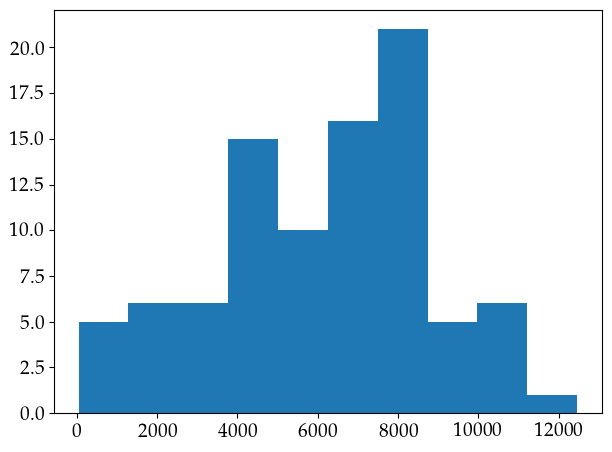

In [287]:
plt.hist(landscape.wealth[landscape.wealth > 0])

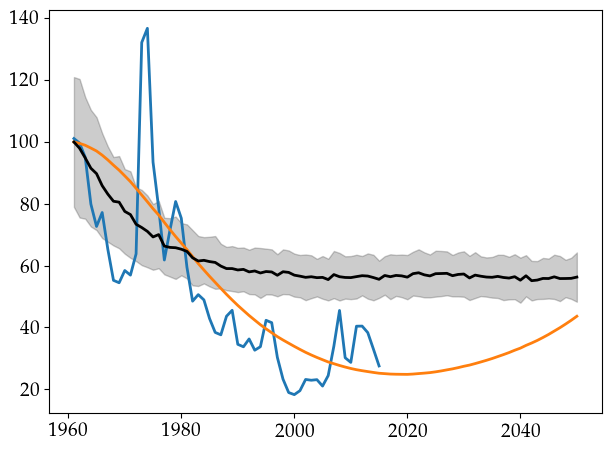

In [258]:

condition = (df_Price.loc[0,:] == 'Wheat') 
condition[0] = True
df_cut = df_Price.loc[1:,condition]

df_cut = df_cut.rename(columns={"Unnamed: 0": "Year", "Unnamed: 12": "Wheat"})
df_cut = df_cut.astype('float')

# # print(df_cut.head())
plt.plot(df_cut['Year'][df_cut['Year'] >= 1961], df_cut['Wheat'][df_cut['Year'] >= 1961]/80 * 100)
years = np.arange(1961, 1961 + len(landscape.data['mean_F']))
plt.plot(years, landscape.data['market_price']/landscape.data['market_price'][0]*100)
plt.plot(years, landscape.data['mean_Price']/landscape.data['mean_Price'][0] * 100, label='Model', c='k')
plt.fill_between(years, np.array(landscape.data['mean_Price'])/landscape.data['mean_Price'][0] * 100 - np.array(landscape.data['std_Price'])/landscape.data['mean_Price'][0] * 100, np.array(landscape.data['mean_Price'])/landscape.data['mean_Price'][0] * 100 + np.array(landscape.data['std_Price'])/landscape.data['mean_Price'][0] * 100, color= 'k', alpha=0.2)
        

In [197]:
landscape.data['mean_Price']

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [87]:
landscape.data['mean_Price']

[120.87073082090838,
 114.71670092426231,
 107.6905842292617,
 98.6730845821768,
 94.02346015065038,
 91.93942040104344,
 85.11816343838026,
 79.0174111737068,
 72.90627392289177,
 68.04364783755456,
 63.05868121603621,
 53.20934344795876,
 51.136761834897165,
 48.390840550564796,
 41.0197073687446,
 37.49534633103136,
 30.78094834596874,
 29.159147280938384,
 25.5115399869121,
 17.242983190217593,
 15.026378390358811,
 8.465661038958322,
 4.441785288683065,
 -0.22672516989205066,
 -4.118903172107238,
 -13.908413411242346,
 -12.411463639926499,
 -22.068055802750887,
 -29.497532342115125,
 -37.14110197899879,
 -41.58916659922395,
 -49.993016272288045,
 -60.851948751317074,
 -63.63466209155856,
 -68.34879010864805,
 -82.03419907114066,
 -94.01025253789037,
 -92.08004923538624,
 -92.71237780307187,
 -108.12339917126575,
 -137.89827947405755,
 -126.71486234899793,
 -142.13930810044383,
 -156.32626917748777,
 -166.31995422488873,
 -172.87654020135645,
 -201.12177049042202,
 -203.72442329249

In [5]:
plt.plot(landscape.productionfunction())

TypeError: Landscape.productionfunction() missing 2 required positional arguments: 'fertilizer' and 'pesticide'

In [ ]:
landscape.productivity

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 7.87134074, 0.        , 7.87219005, 7.87122046],
       [7.87219005, 7.87219005, 0.        , 0.        , 0.        ,
        7.87175554, 0.        , 0.        , 7.8714023 , 7.87136842],
       [0.        , 0.        , 7.87187692, 0.        , 0.        ,
        7.87127272, 0.        , 0.        , 7.87219005, 0.        ],
       [7.87219005, 0.        , 0.        , 7.87219005, 0.        ,
        7.87163704, 0.        , 0.        , 0.        , 7.87169298],
       [0.        , 0.        , 7.87217655, 0.        , 7.87219005,
        7.87112489, 0.        , 7.87153685, 0.        , 7.87219005],
       [7.87123508, 7.87219005, 7.87145287, 0.        , 7.87195585,
        0.        , 7.87145462, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

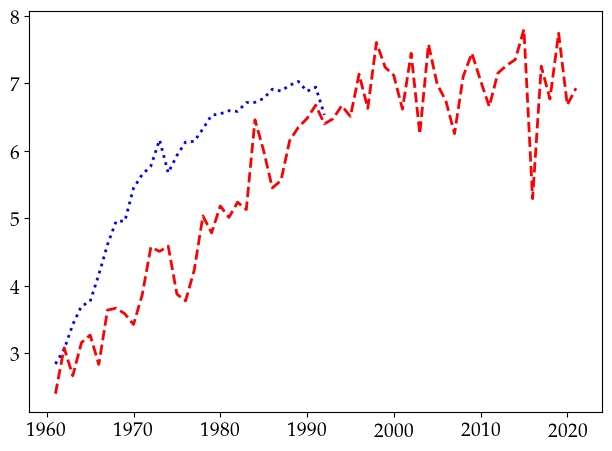

In [25]:
df_F = pd.read_csv('FAO DATA - France/FAOSTAT_data_FERTILIZER.csv')
df_Y = pd.read_csv('FAO DATA - France/FAOSTAT_data_YIELD.csv')
df_P = pd.read_csv('FAO DATA - France/FAOSTAT_data_PESTICIDE.csv')

production = landscape.y_max * (1 - np.exp(-1/landscape.N_req * (df_F['Value'] ))) * (1 - landscape.Maximum_Pest_impact * np.exp(-1/landscape.Pesticides_required * (df_P['Value'] )))
plt.plot(df_F['Year'], production, ls = ':', lw = 2,  color='b')
plt.plot(df_Y['Year'], df_Y['Value']/10000, ls = '--', lw = 2,  color='r')


In [ ]:
landscape.y_max * (1 - np.exp(-1/landscape.N_req * df_F['Value']))

0     2.503256
1     2.699892
2     3.042656
3     3.296539
4     3.360603
        ...   
56    6.302986
57    6.138656
58    5.956371
59    6.141313
60    5.700090
Name: Value, Length: 61, dtype: float64